# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [2]:
import numpy as np
import torch

use_cuda = torch.cuda.is_available()
if use_cuda:
    print("\n///// Using CUDA!\n")
else:
    print("Plain old cpu for now.")


# returns the number of GiB of cuda memory used
def memory_gb():
    max_val = 0
    if (use_cuda):
        gb_alloc = torch.cuda.memory_allocated() / 1024 / 1024 / 1024
        gb_res   = torch.cuda.memory_reserved() /  1024 / 1024 / 1024
        max_val = gb_alloc
        if gb_res > gb_alloc:
            max_val = gb_res
    return max_val

# printable report of cuda memory used
def memory_rpt():
    print("Allocated memory: {:.3f} GB".format(memory_gb()))
    
# finds the index of the element with the largest value in this tensor of shape (1, n)
def max_index(t):
    largest = -1
    largest_index = -1
    for i in range(t.shape[1]):
        if t[0][i] > largest:
            largest = t[0][i]
            largest_index = i
            
    return largest_index
    
memory_rpt()


Plain old cpu for now.
Allocated memory: 0.000 GB


In [3]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("data/lfw/*/*"))
dog_files = np.array(glob("data/dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))
memory_rpt()

There are 13233 total human images.
There are 8351 total dog images.
Allocated memory: 0.000 GB


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

img type =  <class 'numpy.ndarray'>
img shape =  (250, 250, 3)
Number of faces detected: 1


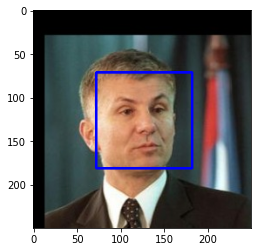

In [2]:
#import sys
#sys.path.append('/usr/local/lib/python3.7/dist-packages')
import cv2                

import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
print("img type = ", type(img))
print("img shape = ", img.shape)
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
The face cascade detector provided found a human face in 99% of the human image sample.
It also found a human face in 7% of the dog image sample!
It would be nice to reduce this false positive probability.

In [4]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

human_count = 0
for img in human_files_short:
    if face_detector(img):
        human_count += 1
print("Found {}% of faces in the human sample.".format(human_count))

dog_count = 0
for img in dog_files_short:
    if face_detector(img):
        dog_count += 1
print("Found {}% of faces in the dog sample.".format(dog_count))

Found 99% of faces in the human sample.
Found 7% of faces in the dog sample.


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [1]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.



# Given that I spent many hours debugging a stupid error in my code (below) that manifested itself as a
# cuda memory error, I have chosen not to do the optional work in this notebook so that I can keep pace
# with completion expectations.  I would normally like to do these extras.  Maybe net time.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [5]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()
    print("/// Using CUDA.")
else:
    print("/// Only using the weenie cpu.")

/// Only using the weenie cpu.


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [6]:
from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    if use_cuda:
        #print("\n/// Using CUDA!\n")
        VGG16.cuda()
    else:
        #print("\n///// Using plain old cpu.\n")
        None
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    normalizer = transforms.Compose([transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])])
    # the following block comes from PyTorch at 
    # https://discuss.pytorch.org/t/how-to-classify-single-image-using-loaded-net/1411
    image = Image.open(img_path)
    image = normalizer(image).float()
    image = image.unsqueeze(0)
    #print("image type = ", type(image))
    #print("image shape = ", image.shape)
    
    ## Return the *index* of the predicted class for that image
    sm = torch.nn.Softmax(dim=1)
    output = VGG16(image)
    #print("output.shape = ", output.shape)
    #print("VGG output = \n", output)
    #print("output max = ", torch.max(output), ", min = ", torch.min(output))

    output = sm(output)
    #print("Softmax output = \n", output)
    #print("output max = ", torch.max(output), ", min = ", torch.min(output))
    res = max_index(output)
    
    #print("End of VGG16_predict. res = ", res)
    return res

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [7]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    
    res = VGG16_predict(img_path)
    
    # in the ImageNet database, dog breeds are contiguous in indices [151, 268] of the full 1000 image classes
    return res >= 151 and res <= 268

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
The human sample returned 0% of them as dogs.  It identified 100% of the dog samples as dogs.

In [9]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

human_count = 0
for img in human_files_short:
    if dog_detector(img):
        human_count += 1
print("Found {}% of dogs in the human sample.".format(human_count))

dog_count = 0
for img in dog_files_short:
    if dog_detector(img):
        dog_count += 1
print("Found {}% of dogs in the dog sample.".format(dog_count))

Found 0% of dogs in the human sample.
Found 100% of dogs in the dog sample.


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [10]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [4]:
import os
from torchvision import datasets
import torchvision.transforms as transforms

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
batch_size = 32
train_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(20),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])
val_transform = transforms.Compose([transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder("data/dogImages/train/", transform=train_transform)
val_data = datasets.ImageFolder("data/dogImages/valid/", transform=val_transform)
test_data = datasets.ImageFolder("data/dogImages/test/", transform=val_transform)
print("train_data size = ", len(train_data))
print("val_data size   = ", len(val_data))
print("test_data size  = ", len(test_data))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader  = torch.utils.data.DataLoader(test_data, batch_size=batch_size)



train_data size =  6680
val_data size   =  835
test_data size  =  836


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:  My code crops the images to 224x224.  For training this is a random crop, in order to help the NN to generalize where to find the dog in the frame.  For val & test it is a center crop.  The tensor representing image data is [N, 3, 224, 224], which represents a batch of N color images (3 color planes).

I am augmenting the training data by randomly moving the crop frame around, flipping the image, and rotating it +/- 20 degrees.  All these should help the NN to generalize to varied situations and to avoid overfitting to the specific training images.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [18]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    
    image_size = 224 #both height & width
    image_planes = 3
    
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        
        self.pool = nn.MaxPool2d(2, 2)
        self.c1 = nn.Conv2d(3, 16, 5, padding=2)
        self.c2 = nn.Conv2d(16, 32, 3, padding=1)
        self.c3 = nn.Conv2d(32, 64, 3, padding=1)

        #FC layers
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(50176, 2000)
        self.fc2 = nn.Linear(2000, 133)
    
    def forward(self, x):
        num_batches = x.shape[0]
        #print("Entering forward: x.shape = ", x.shape, ", num_batches = ", num_batches)
        
        x = F.relu(self.c1(x))        # output 16 x 224 x 224
        x = self.pool(x)              # output 16 x 112 x 112
        x = F.relu(self.c2(x))        # output 32 x 112 x 112
        x = self.pool(x)              # output 32 x 56 x 56
        x = F.relu(self.c3(x))        # output 64 x 56 x 56
        x = self.pool(x)              # output 64 x 28 x 28

        # flatten the image into a vector, one for each item in the batch
        x = x.view(num_batches, -1)   # should be [n, 50176]
        #print("Flattened x shape = ", x.shape)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))

        x = self.dropout(x)
        x = self.fc2(x) #optimizer will apply the Softmax function
        
        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
    print("Model moved to cuda.")
    memory_rpt()

Model moved to cuda.
Allocated memory: 2.096 GB


In [19]:
memory_rpt()
torch.cuda.empty_cache()
memory_rpt()
torch.cuda.device_count()
print(torch.cuda.get_device_name())
print(torch.cuda.get_device_capability())
torch.cuda.ipc_collect()
memory_rpt()

Allocated memory: 2.096 GB
Allocated memory: 1.199 GB
Tesla K80
(3, 7)
Allocated memory: 1.199 GB


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ (Answering prior to any execution) I wanted multiple conv layers that add depth to the image, and occasionally throw in a maxpool to reduce its spatial dimensions, a la VGG. Guessing on adequate number of layers and changes in dimensions, although want to change these gradually; I am not trying to reinvent VGG or similar, so this will be a simpler network; 5 conv layers seems like a good starting point.  Using 3 fully connected layers after the conv to gradually step down the deep image into a classifier.  I expect I'll learn & tweak the architecture after some training attempt.

After some training experience:  I spent a lot of time fighting a memory error on the cuda, due to inadvertent misuse of the <code>loss</code> variable (treating it like an elementary data type).  During that investigation I reduced the size of the model. Also started with a LR = 0.001, then reduced it when I saw that overfitting was still becoming a problem.  I also changed the dropout from 0.2 to 0.25 to help with overfitting.  When first couple models didn't work I increase the number of filters on the cv3 layer from 48 to 64 and adjusted the first fc layer accordingly.  I actually bumped the learning rate back up since it had not yet converged after 200 epochs (5+ hr of GPU time).  It overfit, but capturing the version with min validation loss proved good enough to pass the test.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [20]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = torch.nn.CrossEntropyLoss() # specifies the Softmax function on the output vector

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.005)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [19]:
import time
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, 
          status_interval=0, max_batches=1000000):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    epoch_min = 0
    training_size = len(loaders['train'].dataset)
    valid_size = len(loaders['valid'].dataset)
    print("Entering training. Num training batches = ", len(loaders['train']),
          ", num validation batches = ", len(loaders['valid']))
    print("  Total training dataset size = ", training_size)

    if use_cuda:
        model.cuda()
        print("Moving to CUDA!")
        memory_rpt()
    else:
        print("Using the cpu")

    start_time = time.time()
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        
        # target is a 1D vector of [batch_size], representing the index of each dog identified
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            if (status_interval > 0  and  batch_idx % status_interval == 0):
                print("    Training on batch ", batch_idx, ", memory used = {:.3f} GB".format(memory_gb()))
            #print("target.shape = ", target.shape, ", content =\n", target)

            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## find the loss and update the model parameters accordingly
            optimizer.zero_grad()
            output = model(data) # this is a vector of all breeds showing the probabilities
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            train_loss += loss.item()*data.size(0) #mult by batch size since the CrossEntropy calc divides it out
            
            if batch_idx > max_batches:
                print("\n///// Ending training loop due to artificial batch limit!\n")
                break;

        train_loss /= training_size
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        #print(" Beginning validation.")
        for batch_idx, (datav, targetv) in enumerate(loaders['valid']):
            if (status_interval > 0  and  batch_idx % status_interval == 0):
                print("    Validation on batch ", batch_idx, ", memory used = {:.3f} GB".format(memory_gb()))
            # move to GPU
            if use_cuda:
                datav, targetv = datav.cuda(), targetv.cuda()
            ## update the average validation loss
            outputv = model(datav)
            lossv = criterion(outputv, targetv)
            valid_loss += lossv.item()*datav.size(0)

            if batch_idx > max_batches:
                print("\n///// Ending validation loop due to artificial batch limit!\n")
                break;

        valid_loss /= valid_size
            
        ## TODO: save the model if validation loss has decreased
        saved_flag = ' '
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            epoch_min = epoch
            saved_flag = '*'
            print("Saving model with fc layer: ", model.fc.in_features, model.fc.out_features)

        # print training/validation statistics
        time_per_epoch = float(time.time() - start_time) / float(epoch) / 60.0 #minutes
        time_remaining = float(n_epochs + 1 - epoch) * time_per_epoch / 60.0 #hours
        print('Epoch {}, Train Loss {:.6f}, Val Loss {:.6f}{}, Mem {:.3f} GB, time/epoch {:.1f} m, Remaining {:.1f} hr'.format(
            epoch, train_loss, valid_loss, saved_flag, memory_gb(), time_per_epoch, time_remaining))

    # return trained model
    print("///// Training complete. Best model stored from epoch {}. Memory in use = {:.3f} GB".format(
            epoch_min, memory_gb()))
    return model



In [21]:

# train the model
num_epochs = 200
loaders_scratch = {"train": train_loader,
                   "valid": val_loader,
                   "test":  test_loader}

model_scratch = train(num_epochs, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Entering training. Num training batches =  209 , num validation batches =  27
  Total training dataset size =  6680
Moving to CUDA!
Allocated memory: 1.199 GB
Epoch 1, Train Loss 4.883848, Val Loss 4.870157*, Mem 2.262 GB, time/epoch 1.7 m, Remaining 5.7 hr
Epoch 2, Train Loss 4.861423, Val Loss 4.843199*, Mem 2.262 GB, time/epoch 1.7 m, Remaining 5.7 hr
Epoch 3, Train Loss 4.837504, Val Loss 4.804861*, Mem 2.262 GB, time/epoch 1.7 m, Remaining 5.7 hr
Epoch 4, Train Loss 4.792557, Val Loss 4.723001*, Mem 2.262 GB, time/epoch 1.7 m, Remaining 5.7 hr
Epoch 5, Train Loss 4.715025, Val Loss 4.611552*, Mem 2.262 GB, time/epoch 1.7 m, Remaining 5.6 hr
Epoch 6, Train Loss 4.642607, Val Loss 4.540231*, Mem 2.262 GB, time/epoch 1.7 m, Remaining 5.6 hr
Epoch 7, Train Loss 4.593866, Val Loss 4.513048*, Mem 2.262 GB, time/epoch 1.7 m, Remaining 5.5 hr
Epoch 8, Train Loss 4.561341, Val Loss 4.490680*, Mem 2.262 GB, time/epoch 1.7 m, Remaining 5.5 hr
Epoch 9, Train Loss 4.533867, Val Loss 4.483084*,

Epoch 82, Train Loss 3.084963, Val Loss 4.187664 , Mem 2.637 GB, time/epoch 1.7 m, Remaining 3.3 hr
Epoch 83, Train Loss 3.083603, Val Loss 4.121535 , Mem 2.637 GB, time/epoch 1.7 m, Remaining 3.3 hr
Epoch 84, Train Loss 3.071589, Val Loss 4.199259 , Mem 2.637 GB, time/epoch 1.7 m, Remaining 3.3 hr
Epoch 85, Train Loss 3.056728, Val Loss 4.198259 , Mem 2.637 GB, time/epoch 1.7 m, Remaining 3.2 hr
Epoch 86, Train Loss 3.029770, Val Loss 4.253162 , Mem 2.637 GB, time/epoch 1.7 m, Remaining 3.2 hr
Epoch 87, Train Loss 3.027058, Val Loss 4.202381 , Mem 2.637 GB, time/epoch 1.7 m, Remaining 3.2 hr
Epoch 88, Train Loss 3.018203, Val Loss 4.126077 , Mem 2.637 GB, time/epoch 1.7 m, Remaining 3.2 hr
Epoch 89, Train Loss 3.020841, Val Loss 4.178912 , Mem 2.637 GB, time/epoch 1.7 m, Remaining 3.1 hr
Epoch 90, Train Loss 2.958517, Val Loss 4.196960 , Mem 2.637 GB, time/epoch 1.7 m, Remaining 3.1 hr
Epoch 91, Train Loss 2.963770, Val Loss 4.248662 , Mem 2.637 GB, time/epoch 1.7 m, Remaining 3.1 hr


KeyboardInterrupt: 

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [26]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        #print("pred.shape = ", pred.shape, ", content =\n", pred)
        
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


In [22]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 4.031813


Test Accuracy: 11% (95/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [20]:
## TODO: Specify data loaders
import os
import torch
from torchvision import datasets
import torchvision.transforms as transforms

batch_size = 32
train_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(20),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])
val_transform = transforms.Compose([transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder("data/dogImages/train/", transform=train_transform)
val_data = datasets.ImageFolder("data/dogImages/valid/", transform=val_transform)
test_data = datasets.ImageFolder("data/dogImages/test/", transform=val_transform)
print("train_data size = ", len(train_data))
print("val_data size   = ", len(val_data))
print("test_data size  = ", len(test_data))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader  = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

loaders_transfer = {'train': train_loader,
                    'valid': val_loader,
                    'test':  test_loader}


train_data size =  6680
val_data size   =  835
test_data size  =  836


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [21]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer = models.googlenet(pretrained=True)
print(model_transfer)
print("fc layer features:")
print(model_transfer.fc.in_features, model_transfer.fc.out_features)

# freeze the pretrained params here if desired

dog_classes = 133
dogs_fc = nn.Linear(model_transfer.fc.in_features, dog_classes)
model_transfer.fc = dogs_fc

if use_cuda:
    model_transfer = model_transfer.cuda()
    
print("\n\n/////////// Modified model:\n\n")
print(model_transfer)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
1. Select a pre-trained model from the torchvision library.  We have looked at VGG and ResNet earlier in this class, so I wanted to start with something different, just for the experience.  The GoogleNet looks like pretty good accuracty on ImageNet, and it has an interesting structure. 
2. Since we have a large dataset that is similar to (a subset of) ImageNet, is is reasonable to start with the pretrained conv layers of GoogleNet and simply replace the final FC layer to meet my classification needs.  Then I will train using the GoogleNet pretrained weights, but allow them to be updated by my training (fine tuning).

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [22]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = torch.optim.SGD(model_transfer.parameters(), lr=0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [23]:
# train the model
if use_cuda:
    filename = 'model_transfer_cuda.pt'
else:
    filename = 'model_transfer_cpu.pt'
    
n_epochs = 40
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, 
                       use_cuda, filename, status_interval=0)



Entering training. Num training batches =  209 , num validation batches =  27
  Total training dataset size =  6680
Moving to CUDA!
Allocated memory: 3.568 GB
Saving model with fc layer:  1024 133
Epoch 1, Train Loss 4.633434, Val Loss 4.196186*, Mem 3.846 GB, time/epoch 2.3 m, Remaining 1.5 hr
Saving model with fc layer:  1024 133
Epoch 2, Train Loss 3.933014, Val Loss 3.328928*, Mem 3.850 GB, time/epoch 2.3 m, Remaining 1.5 hr
Saving model with fc layer:  1024 133
Epoch 3, Train Loss 3.227107, Val Loss 2.613661*, Mem 3.850 GB, time/epoch 2.3 m, Remaining 1.5 hr
Saving model with fc layer:  1024 133
Epoch 4, Train Loss 2.665146, Val Loss 2.099158*, Mem 3.850 GB, time/epoch 2.3 m, Remaining 1.4 hr
Saving model with fc layer:  1024 133
Epoch 5, Train Loss 2.276718, Val Loss 1.770722*, Mem 3.850 GB, time/epoch 2.3 m, Remaining 1.4 hr
Saving model with fc layer:  1024 133
Epoch 6, Train Loss 1.999430, Val Loss 1.559835*, Mem 3.850 GB, time/epoch 2.3 m, Remaining 1.4 hr
Saving model with f

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [27]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer_cuda.pt'))

test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.751743


Test Accuracy: 77% (645/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [94]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in train_data.classes]
#print(class_names)
model_transfer.load_state_dict(torch.load('model_transfer_cuda.pt', map_location='cuda:0' if use_cuda else 'cpu'))

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    # the following block comes from PyTorch at 
    # https://discuss.pytorch.org/t/how-to-classify-single-image-using-loaded-net/1411
    image = Image.open(img_path)
    image = app_transform(image).float()
    image = image.unsqueeze(0)
    #print("image type = ", type(image))
    #print("image shape = ", image.shape)

    if use_cuda:
        image = image.cuda()
    
    
    res = model_transfer(image)
    pred = res.data.max(1, keepdim=True)[1].item()
    #print("pred = ", pred)
    
    return class_names[pred]

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [8]:
### TODO: Write your algorithm.

import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# reference a pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

def display_image(image):
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    plt.show()
    
def is_human(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # find faces in image
    faces = face_cascade.detectMultiScale(gray)
    if len(faces) > 0:
        return True
    else:
        return False
    
def is_dog(img_path):
    return dog_detector(img_path)

def run_app(img_path):
    image = cv2.imread(img_path)

    # is it a human face?
    human = is_human(image)
    
    # is it an identifiable dog?
    dog = is_dog(img_path)
    
    # display the image
    print(" ")
    display_image(image)
    
    # display the label as appropriate
    if dog:
        dog_class = predict_breed_transfer(img_path)
        
        if human:
            print("It's a human who looks like a", dog_class)
        else:
            print(dog_class)
    
    elif human:
        print("It's a human.")
    
    else:
        print("Undetectable object!")
    
    print("\n")


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.
 

__Answer:__ (Three possible points for improvement)
It is about what I expected based on test results above.  The human recognition was correct on 4/5 of the humans, but incorrectly identified 1/3 dogs and a comic strip as human.  The comic is understandable, as it is a drawing of two humans.  This is not bad.  The dog classifier was correct on 2/3 dogs.  As a classifier, it must return a class for any image presented; it will never say "not a dog", so the classifications for humans and comic strips are just frivolous and not to be counted against it.

Possible points for improvement:

1) Pay attention to the image sizes.  I did not try to scale them at all, and some are very large.  I had the algorithm resize them to 224 on short edge, but it isn't clear to me how well that worked.  Paying more attention to the quality of the input images may make a difference.

2) Test with a larger data set.  3 dogs is not statistically significant. I would expect that presenting more dog images would get the results closer to the official test accuracy of 77%, but 2/3 is as close as possible with what I had.

3) I could definitely spend more time tuning the model parameters (learning rate, number of training epochs).  This is the result of two passes at the training.  I suspect that, with more time, 80-85% accuracy is within reach.

4) If #3 doesn't pan out, I could certainly try another pre-trained network as the basis for the dog classifier.


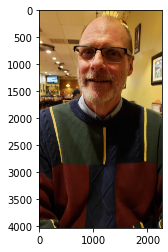

It's a human that looks like a  Pharaoh hound


 


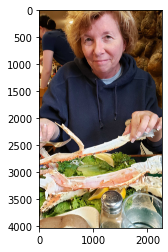

It's a human that looks like a  Poodle


 


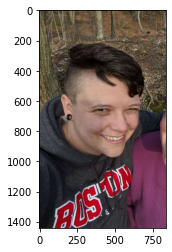

It's a human that looks like a  Poodle


 


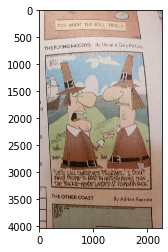

It's a human that looks like a  Dalmatian


 


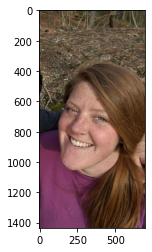

Chinese crested


 


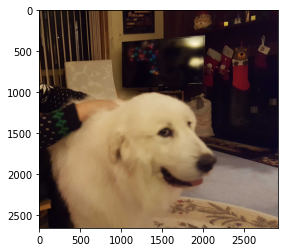

It's a human that looks like a  Great pyrenees


 


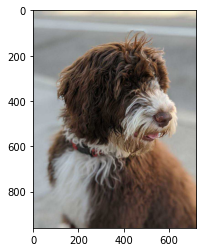

Wirehaired pointing griffon


 


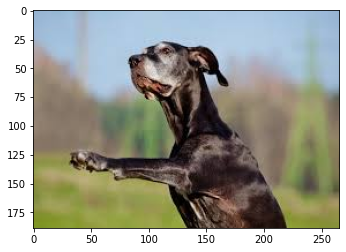

Great dane


 


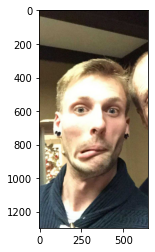

It's a human that looks like a  Chinese crested




In [98]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
import numpy as np
from glob import glob
from torchvision import datasets
import torchvision.transforms as transforms
from PIL import Image

test_images = np.array(glob("data/inference/all/*"))

app_transform = transforms.Compose([transforms.Resize(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

#app_data = datasets.ImageFolder("data/inference", transform=app_transform)


## suggested code, below
for item in test_images:
    run_app(item)